# CASE STUDY: CODED BY SUMEET ROUTRAY

IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime #import dattime libraries

READING INPUTA DATA

In [3]:
df1 = pd.read_csv("TrainingData_V1.csv")
df2 = pd.read_excel("TestingData_For_Candidate.xlsx", sheet_name= "Sheet1")

In [4]:
#Creating an indicator for train-test split
df1["train_test_indicator"]="train"
df2["train_test_indicator"]="test"

In [5]:
for col in ['order_date','delivery_date','user_dob','user_reg_date']:
    df2[col] = df2[col].dt.strftime("%d-%m-%Y")

In [6]:
df=df1.append(df2, ignore_index = True) # appnding the datasets

PRE-PROCESSING AND CLEANSING OF DATA

In [7]:
#Converting to date-type
for col in ['order_date','delivery_date','user_dob','user_reg_date']:
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)

In [8]:
df['Delivery_days']= np.trunc((df['delivery_date'] - df['order_date'])/np.timedelta64(1,'D'))#Crating column from existing ones

In [9]:
df['User_Age']= np.trunc((df['order_date'] - df['user_dob'])/np.timedelta64(1,'Y'))#Crating column from existing ones

In [10]:
df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,train_test_indicator,Delivery_days,User_Age
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.9,30822,Mrs,1969-04-17,1013,2016-06-23,0.0,train,5.0,47.0
1,10,2016-06-22,2016-06-27,195,xxl,grey,46,19.9,30823,Mrs,1970-04-22,1001,2015-03-15,1.0,train,5.0,46.0
2,11,2016-06-22,2016-07-05,25,xxl,grey,5,79.9,30823,Mrs,1970-04-22,1001,2015-03-15,0.0,train,13.0,46.0
3,32,2016-06-23,2016-06-26,173,m,brown,20,19.9,17234,Mrs,1960-01-09,1013,2015-02-17,0.0,train,3.0,56.0
4,43,2016-06-23,2016-06-26,394,40,black,44,90.0,30827,Mrs,NaT,1006,2016-02-09,1.0,train,3.0,NaN


In [11]:
#VALIDATION CHECKS
df = df.dropna(how='any', subset=['delivery_date'])
df=df[df['Delivery_days']>=0]

In [13]:
df_train=df[df['train_test_indicator']=="train"]
df_test=df[df['train_test_indicator']=="test"]

In [14]:
print("train",df_train.shape)
print("test",df_test.shape)

train (71663, 17)
test (17947, 17)


In [15]:
df_test=df_test[df_test['item_id'].isin(df_train['item_id'].unique())]#item_ids selected in test data those are present in train

In [16]:
df_test.shape

(17895, 17)

OUTLIER TREATMENT

In [17]:
print(min(df_train['User_Age']))
print(max(df_train['User_Age']))

4.0
115.0


In [18]:
#Using mean+-3*std.dev method
LL=df_train['User_Age'].mean() - 3*df_train['User_Age'].std()
UL=df_train['User_Age'].mean() + 3*df_train['User_Age'].std()
print("Lowest allowed",LL)
print("Highest allowed",UL)
((df_train['User_Age'] < LL) | (df_train['User_Age'] > UL)).sum()

Lowest allowed 18.1875060404912
Highest allowed 85.58820204050225


927

In [19]:
#CAPPING
upper_limit = df_train['User_Age'].mean() + 3*df_train['User_Age'].std()
lower_limit = df_train['User_Age'].mean() - 3*df_train['User_Age'].std()

df_train['User_Age'] = np.where(df_train['User_Age']>upper_limit,upper_limit,
                 np.where(df_train['User_Age']<lower_limit,lower_limit, df_train['User_Age']))

In [20]:
print(min(df_train['User_Age']))
print(max(df_train['User_Age']))

18.1875060404912
85.58820204050225


In [21]:
#INTER QUARTILE RANGE METHOD

# Q1 = df_train['User_Age'].quantile(0.25)
# Q3 = df_train['User_Age'].quantile(0.75)
# IQR = Q3 - Q1
# LL= Q1 - 1.5 * IQR
# UL= Q3 + 1.5 * IQR
# print("Lowest allowed",LL)
# print("Highest allowed",UL)
# ((df_train['User_Age'] < LL) | (df_train['User_Age'] > UL)).sum()
# Lowest allowed 28.5
# Highest allowed 72.5
# 1833

In [22]:
#Outliers handled for test data in a similar fashion
upper_limit = df_test['User_Age'].mean() + 3*df_test['User_Age'].std()
lower_limit = df_test['User_Age'].mean() - 3*df_test['User_Age'].std()

df_test['User_Age'] = np.where(df_test['User_Age']>upper_limit,upper_limit,
                 np.where(df_test['User_Age']<lower_limit,lower_limit, df_test['User_Age']))

HANDLING MISSING VALUES

In [23]:
df_train['User_Age'].isnull().sum()

6275

In [24]:
df_train.groupby('user_title')['User_Age'].mean()

user_title
Company         51.555556
Family          48.578014
Mr              51.595794
Mrs             51.501745
not reported    54.205882
Name: User_Age, dtype: float64

In [25]:
#Missing values handled through group means by a separate column (train & test data separately)

df_train['User_Age'] = df_train['User_Age'].fillna(df_train.groupby('user_title')['User_Age'].transform('mean'))
df_train['User_Age'].isnull().sum()

0

In [26]:
df_test['User_Age'] = df_test['User_Age'].fillna(df_test.groupby('user_title')['User_Age'].transform('mean'))
df_test['User_Age'].isnull().sum()

0

In [27]:
df_train['item_color'].unique()

array(['navy', 'grey', 'brown', 'black', 'bordeaux', 'white', 'purple',
       'magenta', 'stained', 'blue', 'red', 'olive', 'ocher', 'ash',
       'khaki', 'nature', 'denim', 'curry', 'beige', 'turquoise', 'green',
       'anthracite', 'yellow', 'berry', 'petrol', 'brwon', 'dark denim',
       'hibiscus', 'azure', 'ecru', 'gold', 'orange', 'silver',
       'darkblue', 'mocca', 'mint', 'pink', 'copper coin', 'jade', 'blau',
       'aqua', 'cobalt blue', 'mango', 'champagner', 'aubergine',
       'cognac', 'fuchsia', 'pallid', 'aquamarine', 'terracotta',
       'aviator', 'ancient', 'curled', 'apricot', 'coral', 'basalt',
       'floral', 'creme', 'mahagoni', 'dark garnet', 'striped', 'ivory',
       '?', 'dark oliv', 'dark navy', 'antique pink', 'habana',
       'dark grey', 'amethyst', 'currant purple', 'kanel', 'ebony',
       'avocado', 'caramel', 'baltic blue', 'almond', 'opal'],
      dtype=object)

In [28]:
df_train['item_color'].nunique()

77

In [29]:
#Replace '?' categories by NaN
df_train['item_color']=df_train['item_color'].replace("?",np.NaN)
df_test['item_color']=df_test['item_color'].replace("?",np.NaN)

In [30]:
print("train_null",df_train['item_color'].isnull().sum())
print("test_null",df_test['item_color'].isnull().sum())

train_null 47
test_null 11


In [31]:
#Missing values handled through maximum frequency/mode
df_train['item_color'].fillna(df_train['item_color'].mode()[0], inplace=True)
df_test['item_color'].fillna(df_test['item_color'].mode()[0], inplace=True)

In [32]:
df_train['item_color'].value_counts()

black       13528
blue         7590
brown        6338
grey         6256
red          5111
            ...  
caramel         4
ebony           4
opal            2
creme           2
amethyst        2
Name: item_color, Length: 76, dtype: int64

CONVERTING CATEGORICAL TO CONTINUOUS VIA "TARGET MEAN ENCODING" TECHNIQUE

In [33]:
df_test["item_size"]= df_test["item_size"].astype(str)

In [34]:
for enc_vars in ['item_id','item_size','item_color','brand_id']:
    mean_encode=df_train.groupby(enc_vars)['return'].mean()
    df_train.loc[:,enc_vars+"_enc"]=df_train[enc_vars].map(mean_encode)
    df_test.loc[:,enc_vars+"_enc"]=df_test[enc_vars].map(mean_encode)
    print("train_null_"+enc_vars,df_train[enc_vars].isnull().sum())
    print("test_null_"+enc_vars,df_test[enc_vars].isnull().sum())

train_null_item_id 0
test_null_item_id 0
train_null_item_size 0
test_null_item_size 0
train_null_item_color 0
test_null_item_color 0
train_null_brand_id 0
test_null_brand_id 0


In [35]:
print(df_train['user_title'].value_counts())
print(df_test['user_title'].value_counts())

Mrs             68488
Mr               2729
Family            264
Company           104
not reported       78
Name: user_title, dtype: int64
Mrs             17130
Mr                668
Family             57
Company            23
not reported       17
Name: user_title, dtype: int64


CREATING DUMMIES FOR CATEGORICAL VARIABLES

In [36]:
df_train.groupby(['return','user_title']).size().unstack(fill_value=0) #Chcking 'user_title' categorical variable

user_title,Company,Family,Mr,Mrs,not reported
return,,,,,
0.0,40,141,1418,33672,47
1.0,64,123,1311,34816,31


In [37]:
df_train['return'].value_counts() # Event rate

1.0    36345
0.0    35318
Name: return, dtype: int64

In [38]:
#Creating dummies for train & test data
df_train_state_dummies=pd.get_dummies(df_train['user_state'],drop_first=True)
df_test_state_dummies=pd.get_dummies(df_test['user_state'],drop_first=True)

In [39]:
df_train_user_dummies=pd.get_dummies(df_train['user_title'],drop_first=True)
df_test_user_dummies=pd.get_dummies(df_test['user_title'],drop_first=True)

CREATING A CATEGORICAL VARIABLE FROM CONTINUOUS THROUGH BINNING

In [40]:
#Creating Customer_Tenure variable & then binning it to form Customer_Category in both train & test data

df_train["Customer_Tenure"]=np.trunc((df_train['order_date'] - df_train['user_reg_date'])/np.timedelta64(1,'D'))
df_test["Customer_Tenure"]=np.trunc((df_test['order_date'] - df_test['user_reg_date'])/np.timedelta64(1,'D'))

In [41]:
df_train["Customer_Category"]=pd.cut(df_train.Customer_Tenure,bins=[-5,30,365,600],labels=['New_Customer','Slightly_Old_Customer','Old_Customer'])

In [42]:
df_train.groupby(['return','Customer_Category']).size().unstack(fill_value=0)

Customer_Category,New_Customer,Slightly_Old_Customer,Old_Customer
return,,,
0.0,9058,11687,14573
1.0,8961,11582,15802


In [43]:
dt=pd.crosstab(index=df_train['return'], columns=df_train['Customer_Category']) #Creating a contingency table

CHI-SQUARE TEST FOR 'Customer_Category' VARIABLE

In [44]:
#Checking null hypothesis is approved or rejected
from scipy.stats import chi2_contingency
data = dt
stat, p, dof, expected = chi2_contingency(data)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 1.5139447020139232e-08
Dependent (reject H0)


In [45]:
df_test["Customer_Category"]=pd.cut(df_test.Customer_Tenure,bins=[-5,30,365,600],labels=['New_Customer','Slightly_Old_Customer','Old_Customer'])

In [46]:
#Creating dummies for the same variable
df_train_cust_dummies=pd.get_dummies(df_train['Customer_Category'],drop_first=True)
df_test_cust_dummies=pd.get_dummies(df_test['Customer_Category'],drop_first=True)

<AxesSubplot:>

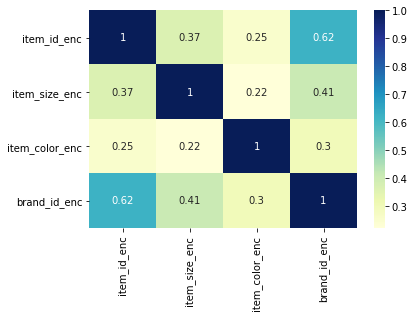

In [47]:
#Checking the correlatin matrix
import seaborn as sns
sns.heatmap(df_train[['item_id_enc','item_size_enc','item_color_enc','brand_id_enc']].corr(),cmap="YlGnBu", annot=True)

In [48]:
#CREATING BACK-UPS

df_train_bkp=df_train.copy()
df_test_bkp=df_test.copy()

In [49]:
df_train=df_train_bkp.copy()
df_test=df_test_bkp.copy()

In [51]:
#Concatenating continuous & dummies to form the final data sets
df_train=pd.concat([df_train[['Delivery_days','item_id_enc','item_size_enc','item_color_enc','brand_id_enc',
                             'item_price','User_Age','return']],
                              df_train_user_dummies,df_train_state_dummies,df_train_cust_dummies],axis=1)
df_test=pd.concat([df_test[['order_item_id','Delivery_days','item_id_enc','item_size_enc','item_color_enc','brand_id_enc',
                             'item_price','User_Age','return']],
                              df_test_user_dummies,df_test_state_dummies,df_test_cust_dummies],axis=1)

In [140]:
# df_train=pd.concat([df_train[['Delivery_days','item_id_enc','item_size_enc','item_color_enc','brand_id_enc',
#                              'item_price','User_Age','return']],
#                               df_train_user_dummies,df_train_state_dummies,df_train_cust_dummies],axis=1)
# df_test=pd.concat([df_test[['Delivery_days','item_id_enc','item_size_enc','item_color_enc','brand_id_enc',
#                              'item_price','User_Age','return']],
#                               df_test_user_dummies,df_test_state_dummies,df_test_cust_dummies],axis=1)

In [52]:
df_train.head()

,Delivery_days,item_id_enc,item_size_enc,item_color_enc,brand_id_enc,item_price,User_Age,return,Family,Mr,...,1009,1010,1011,1012,1013,1014,1015,1016,Slightly_Old_Customer,Old_Customer
0,5.0,0.235294,0.522085,0.368932,0.398649,49.9,47.000000,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5.0,0.418182,0.470209,0.531490,0.514104,19.9,46.000000,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,13.0,0.484848,0.470209,0.531490,0.468740,79.9,46.000000,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,0.698885,0.493287,0.536289,0.622444,19.9,56.000000,0.0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,3.0,0.627451,0.555998,0.514710,0.591647,90.0,51.501745,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [53]:
df_test.head()

,order_item_id,Delivery_days,item_id_enc,item_size_enc,item_color_enc,brand_id_enc,item_price,User_Age,return,Family,...,1009,1010,1011,1012,1013,1014,1015,1016,Slightly_Old_Customer,Old_Customer
79945,26,3.0,0.333333,0.496260,0.497696,0.489162,69.90,54.0,NaN,0,...,0,1,0,0,0,0,0,0,1,0
79946,28,9.0,0.469388,0.470209,0.475862,0.458054,19.90,54.0,NaN,0,...,0,1,0,0,0,0,0,0,1,0
79947,37,3.0,0.584821,0.522085,0.487022,0.548673,39.95,52.0,NaN,0,...,0,0,0,0,0,0,0,0,0,1
79950,80,3.0,0.323944,0.492143,0.470396,0.397278,24.90,46.0,NaN,0,...,0,0,0,0,0,0,0,0,1,0
79951,95,3.0,0.323944,0.496260,0.507723,0.397278,34.90,67.0,NaN,0,...,0,0,0,0,0,0,1,0,1,0


MODELING USING DIFFERENT ALGORITHMS

In [ ]:
#Selecting dependent & independent variables
df_train_X=df_train.drop('return',axis=1)
df_train_Y=df_train['return']

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
#Train-Validation split
X_train,X_val,Y_train,Y_val=train_test_split(df_train_X,df_train_Y,test_size=0.3,random_state=101)

In [75]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(50164, 28)
(50164,)
(21499, 28)
(21499,)


DECISION TREE

In [114]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [149]:
dtree=DecisionTreeClassifier()

In [79]:
n_folds=5 #folds for Cross-validation

In [151]:
#Creating param-grid from selecting best set of hyper-parameters from the param-grid space
param_grid={'max_depth': range(5,15,5),
           'criterion': ['entropy','gini']}

In [152]:
grid_search=GridSearchCV(estimator=dtree,param_grid=param_grid,cv=n_folds,verbose=1)#Using gridsearch CV

In [153]:
grid_search.fit(X_train,Y_train)#fitting the model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.7s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5)},
             verbose=1)

In [156]:
cv_results=pd.DataFrame(grid_search.cv_results_)

In [157]:
cv_results #showing all possible results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252280,0.053752,0.016194,0.008100,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.637895,0.631815,0.634406,0.628028,0.626894,0.631808,0.004056,1
1,0.425159,0.039539,0.011295,0.002308,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.628227,0.623642,0.623144,0.619854,0.618720,0.622717,0.003334,3
2,0.224857,0.016101,0.013806,0.003363,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.637197,0.631217,0.634406,0.628028,0.627093,0.631588,0.003806,2
3,0.396868,0.024477,0.012980,0.000880,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.621449,0.619755,0.622845,0.616864,0.610247,0.618232,0.004463,4


In [166]:
#Selecting best heper-parameters
best_param_max_depth=grid_search.best_params_.get("max_depth")
best_param_criterion=grid_search.best_params_.get("criterion")

In [ ]:
#criterion: entropy
#max_depth: 5

In [170]:
#fitting the model with the optimal parameters
dtree_best=DecisionTreeClassifier(max_depth=best_param_max_depth,criterion=best_param_criterion)
dtree_best.fit(X_train,Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [ ]:
Y_pred=dtree_best.predict_proba()#predicting

In [61]:
from sklearn.metrics import roc_auc_score

In [173]:
#Computing Validation-AUC score
Y_pred=dtree_best.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_pred)

0.6702318213796128

RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Import RF library

In [176]:
rf=RandomForestClassifier()

In [182]:
#Providing hyper-parameter space through param-grid
param_grid={"max_depth": range(5,15,5),
            "n_estimators": [100,200,300,400,500],
            "max_features": [5,10,15,20,25],
            "criterion": ["entropy","gini"]}

In [183]:
grid_search_rf= GridSearchCV(estimator=rf,param_grid=param_grid,cv=n_folds,verbose=1,scoring="roc_auc")

In [184]:
grid_search_rf.fit(X_train,Y_train)#fitting the model through grid-search

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 254.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'max_features': [5, 10, 15, 20, 25],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='roc_auc', verbose=1)

In [185]:
cv_results_rf=pd.DataFrame(grid_search_rf.cv_results_)
cv_results_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.292910,0.131676,0.167140,0.005537,entropy,5,5,100,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.682658,0.678793,0.685636,0.669396,0.668317,0.676960,0.006972,95
1,6.461277,0.190989,0.333885,0.046683,entropy,5,5,200,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.683850,0.678582,0.684992,0.670488,0.668342,0.677251,0.006787,92
2,9.413540,0.057628,0.456435,0.008330,entropy,5,5,300,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.684206,0.676993,0.684358,0.669943,0.668062,0.676713,0.006861,97
3,12.246904,0.053706,0.592449,0.008673,entropy,5,5,400,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.683198,0.677849,0.684293,0.670003,0.667800,0.676629,0.006712,98
4,15.602071,0.089389,0.746025,0.013125,entropy,5,5,500,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.684296,0.677707,0.684919,0.670779,0.667595,0.677059,0.006980,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16.694290,0.041676,0.241922,0.001701,gini,10,25,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.690035,0.685304,0.691104,0.676819,0.677910,0.684234,0.005949,70
96,35.132709,3.023341,0.493758,0.039465,gini,10,25,200,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.691189,0.685466,0.690685,0.677731,0.678157,0.684645,0.005829,50
97,51.212970,1.580567,0.722784,0.041189,gini,10,25,300,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.690774,0.685658,0.690926,0.677244,0.677777,0.684476,0.005997,57
98,41.686685,13.612231,0.542948,0.194347,gini,10,25,400,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.691471,0.685874,0.690766,0.677544,0.677905,0.684712,0.006023,44


In [191]:
#Selecting optimal parametrs
best_param_max_depth_rf=grid_search_rf.best_params_.get("max_depth")
best_param_n_estimators_rf=grid_search_rf.best_params_.get("n_estimators")
best_param_max_features_rf=grid_search_rf.best_params_.get("max_features")
best_param_criterion_rf=grid_search_rf.best_params_.get("criterion")

In [195]:
best_param_n_estimators_rf

400

In [ ]:
#max_depth: 10
#n_estmators: 400
#max_featues: 10
#criterion: entropy

In [196]:
#Fitting the model with optimal parameters
rf_best=RandomForestClassifier(max_depth=best_param_max_depth_rf,n_estimators=best_param_n_estimators_rf,
                              max_features=best_param_max_features_rf,criterion=best_param_criterion_rf)
rf_best.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10,
                       n_estimators=400)

In [197]:
#Computing Validation-AUC score
Y_pred_rf=rf_best.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_pred_rf)

0.6764268511677428

LOGISTIC REGRESSION

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
lr=LogisticRegression()

In [80]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train, Y_train, scoring='roc_auc', cv=n_folds, n_jobs=-1)

In [81]:
scores

array([0.68966435, 0.68795443, 0.68968873, 0.67733043, 0.67703639])

In [82]:
sum(scores)/len(scores)

0.6843348654723348

In [92]:
lr.fit(X_train, Y_train) #Fitting the model

LogisticRegression()

In [103]:
Y_pred_lr=lr.predict_proba(X_val)[:,1] #predicting on validation data

In [105]:
#Computing Validation-AUC score
roc_auc_score(Y_val,Y_pred_lr)

0.6737276606340082

XG-BOOST

In [58]:
#Importing libraries for XG-Boost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [59]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [54]:
target = 'return'
#IDcol = 'item_id'

In [60]:
from sklearn import metrics

In [55]:
#Creating separate splits of train & validation data
msk = np.random.rand(len(df_train)) < 0.8
train = df_train[msk]
val  = df_train[~msk]

In [67]:
#Defining a function for XG-Boost fitting using cross-validation & stopping_rounds; 
#also returning train-validation Accuracy-AUC scores 
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['return'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy_train : %.4g" % metrics.accuracy_score(dtrain['return'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['return'], dtrain_predprob))
    dval_predictions = alg.predict(val[predictors])
    dval_predprob = alg.predict_proba(val[predictors])[:,1]
    print ("Accuracy_val : %.4g" % metrics.accuracy_score(val['return'].values, dval_predictions))
    print ("AUC Score (val): %f" % metrics.roc_auc_score(val['return'], dval_predprob))
    print(alg.set_params(n_estimators=cvresult.shape[0]))
    
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')



Model Report
Accuracy_train : 0.6971
AUC Score (Train): 0.778982
Accuracy_val : 0.6291
AUC Score (val): 0.678239
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=32, n_jobs=8, nthread=-1, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


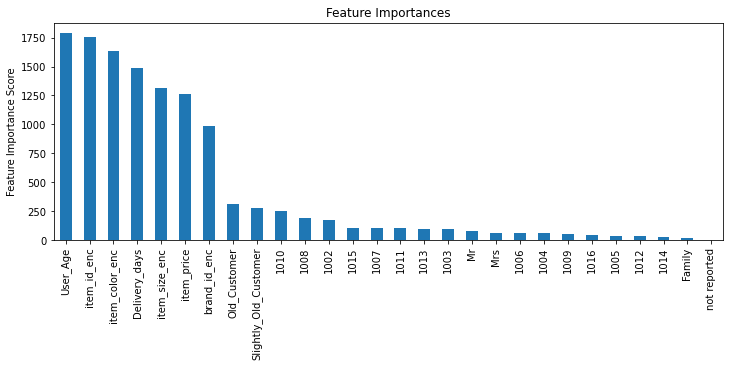

In [68]:
#passing parameters to XGB (1st step: identifying the number of trees/n_estimators with a high learning rate)
predictors = [x for x in train.columns if x not in [target]]#Set of independent variables
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
#  objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [249]:
#n_estimators=32

In [115]:
#Parameter tuning of tree_features by setting the optimal value of n_estiamaters
param_test1 = {
 'max_depth':range(3,15,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=32,
 gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[02:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=32, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_me

In [116]:
cv_results_xgb=pd.DataFrame(gsearch1.cv_results_)
cv_results_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.544093,0.063434,0.028935,0.004536,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.683023,0.688022,0.678574,0.682985,0.674939,0.681509,0.004442,8
1,1.440733,0.032700,0.028550,0.003038,3,3,"{'max_depth': 3, 'min_child_weight': 3}",0.683029,0.688022,0.678563,0.682984,0.674836,0.681487,0.004475,9
2,1.474021,0.033053,0.030828,0.001629,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.683026,0.688021,0.678563,0.682939,0.674809,0.681472,0.004479,10
3,2.784468,0.058591,0.031855,0.006988,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.683395,0.688984,0.679545,0.685816,0.676215,0.682791,0.004509,2
4,2.610554,0.077449,0.033537,0.004104,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.683516,0.688865,0.679534,0.686021,0.675761,0.682739,0.004645,3
5,2.675755,0.068798,0.036893,0.005122,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.683570,0.688990,0.679456,0.685709,0.675909,0.682727,0.004604,4
6,4.003752,0.044718,0.035222,0.004369,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.683106,0.690029,0.680424,0.685812,0.675018,0.682878,0.005052,1
7,3.922217,0.084039,0.033794,0.001143,7,3,"{'max_depth': 7, 'min_child_weight': 3}",0.683456,0.689806,0.679456,0.685837,0.674763,0.682664,0.005185,5
8,3.978847,0.072159,0.034752,0.003862,7,5,"{'max_depth': 7, 'min_child_weight': 5}",0.683659,0.689656,0.679953,0.685345,0.674493,0.682621,0.005122,6
9,5.570499,0.073526,0.038646,0.004617,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.681566,0.687731,0.678534,0.686690,0.673925,0.681689,0.005134,7


In [117]:
#Selecting best tree_fetures
best_param_max_depth_xgb=gsearch1.best_params_.get("max_depth")
best_param_min_child_weight_xgb=gsearch1.best_params_.get("min_child_weight")

In [119]:
best_param_min_child_weight_xgb

1

In [260]:
#max_depth: 7 
#min_child_weight: 1


Model Report
Accuracy_train : 0.6502
AUC Score (Train): 0.713319
Accuracy_val : 0.63
AUC Score (val): 0.677659
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=32, n_jobs=8, nthread=-1, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


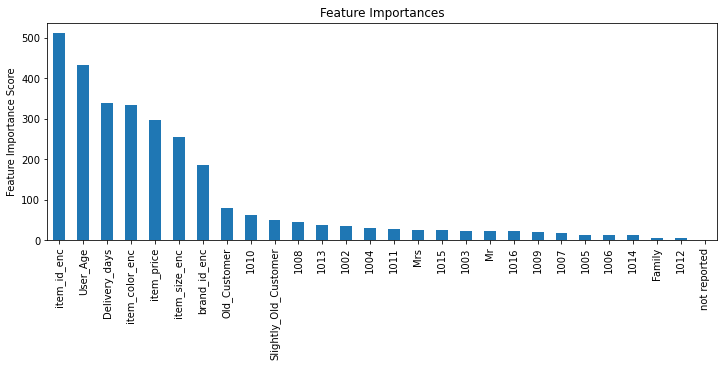

In [120]:
#passing optimal n_estimators & tree_features to check train-validation Accuracy & AUC
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=32,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
#  objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [121]:
#hyper-parameter tuning for gamma (which is used for x-treme pruning of trees)
param_test1 = {
 'gamma':range(0,5,1),
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=32, max_depth=7,
 min_child_weight=1,
 subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[02:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=32, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_meth

In [122]:
best_param_gamma_xgb=gsearch1.best_params_.get("gamma")#selecting best gamma

In [123]:
best_param_gamma_xgb

2

In [ ]:
#gamma: 2

In [124]:
#Tuning for subsample & colsample by fixing rest of the hyper-parameters already obtained
param_test1 = {
  'subsample':[i/10.0 for i in range(6,10)],
  'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=32, max_depth=7,
 min_child_weight=1, gamma=2,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[02:42:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=2,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=32, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_metho

In [125]:
#Selecting best colsumple & subsample
best_param_subsample_xgb=gsearch1.best_params_.get("subsample")
best_param_colsample_bytree_xgb=gsearch1.best_params_.get("colsample_bytree")

In [127]:
best_param_colsample_bytree_xgb

0.8

In [ ]:
#subsample: 0.8
#colsample_bytree: 0.8


Model Report
Accuracy_train : 0.6418
AUC Score (Train): 0.699715
Accuracy_val : 0.6262
AUC Score (val): 0.676687
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=32, n_jobs=8, nthread=-1, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


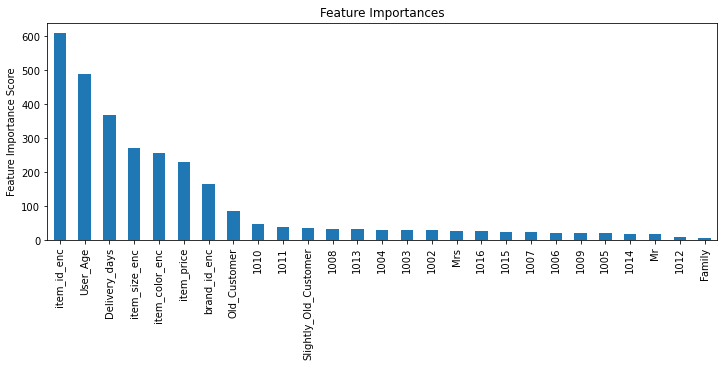

In [128]:
#Setting all hyper-parameters to optimal-obtained values and fitting the model with a lower step-size/learning rate 
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=32,
 max_depth=7,
 min_child_weight=1,
 gamma=2,
 subsample=0.8,
 colsample_bytree=0.8,
#  objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

FITTING THE MODEL ON THE ENTIRE TRAIN DATA SET WITH OPTIMAL HYPER-PARAMETERS

In [129]:
#Fitting the model with optimal parameters
xgb_best=XGBClassifier(subsample=0.8,scale_pos_weight=1,n_estimators=32,min_child_weight=1,
                       max_depth=7,learning_rate=0.01,gamma=2,colsample_bytree=0.8)

In [131]:
xgb_best.fit(df_train[predictors],df_train['return'])

[02:51:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=32, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

PREDICTING ON TRAIN AS WELL AS TEST DATA SET


Model Report
Accuracy_train : 0.6397
AUC Score (Train): 0.696059


Text(0, 0.5, 'Feature Importance Score')

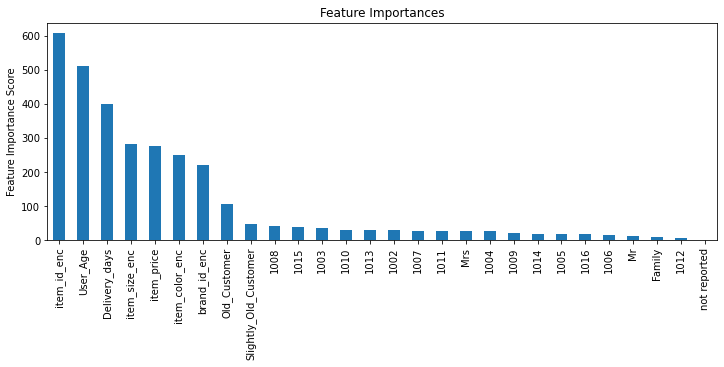

In [133]:
#Predict training set:
df_train_predictions = xgb_best.predict(df_train[predictors])
df_train_predprob = xgb_best.predict_proba(df_train[predictors])[:,1]

        
#Print model report:
print ("\nModel Report")
print ("Accuracy_train : %.4g" % metrics.accuracy_score(df_train['return'].values, df_train_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(df_train['return'], df_train_predprob))

#Predicting on Test Data
df_test['Predicted'] = xgb_best.predict(df_test[predictors])
df_test['Predicted_Prob'] = xgb_best.predict_proba(df_test[predictors])[:,1]

#Feature Importance                
feat_imp = pd.Series(xgb_best.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [134]:
df_test.head()

,order_item_id,Delivery_days,item_id_enc,item_size_enc,item_color_enc,brand_id_enc,item_price,User_Age,return,Family,...,1011,1012,1013,1014,1015,1016,Slightly_Old_Customer,Old_Customer,Predicted,Predicted_Prob
79945,26,3.0,0.333333,0.496260,0.497696,0.489162,69.90,54.0,NaN,0,...,0,0,0,0,0,0,1,0,0.0,0.464720
79946,28,9.0,0.469388,0.470209,0.475862,0.458054,19.90,54.0,NaN,0,...,0,0,0,0,0,0,1,0,0.0,0.477400
79947,37,3.0,0.584821,0.522085,0.487022,0.548673,39.95,52.0,NaN,0,...,0,0,0,0,0,0,0,1,1.0,0.515854
79950,80,3.0,0.323944,0.492143,0.470396,0.397278,24.90,46.0,NaN,0,...,0,0,0,0,0,0,1,0,0.0,0.463179
79951,95,3.0,0.323944,0.496260,0.507723,0.397278,34.90,67.0,NaN,0,...,0,0,0,0,1,0,1,0,0.0,0.453945


In [135]:
#Creating the final data set
df_final=df_test[['order_item_id','Predicted']]

In [136]:
delv_df=pd.merge(df2,df_final,on='order_item_id',how='left')#merge the predicted values to the test-data(initially read) set

In [139]:
delv_df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,Predicted
0,26,23-06-2016,26-06-2016,92,xl,turquoise,42,69.90,9392,Mrs,14-04-1962,1010,24-03-2016,0.0
1,28,23-06-2016,02-07-2016,2,xxl,green,2,19.90,9392,Mrs,14-04-1962,1010,24-03-2016,0.0
2,37,23-06-2016,26-06-2016,895,38,white,39,39.95,30826,Mrs,27-04-1964,1001,17-02-2015,1.0
3,56,23-06-2016,NaN,5,l,white,5,69.90,30828,Mrs,13-05-1966,1008,21-01-2016,NaN
4,65,23-06-2016,NaN,55,40,purple,1,89.90,22948,Mrs,11-03-1957,1001,17-02-2015,NaN


In [138]:
delv_df.drop("train_test_indicator",axis=1,inplace=True)#dropping train_test indicator variable

Since some of the delivery dates are missing in the test data and some of them have delivery dates which are far earlier than order date, we assume that for those line items predicted values would be zero since there would be no chance of return

In [140]:
delv_df.to_csv("Predicted_Test_Data_SumeetRoutray.csv")#writing the final output(consisting of predicted column) to csv

# ------------------------------------------THE END-----------------------------------------------